# TinyBERT for Fake News Detection

## 1. Introduction

This notebook demonstrates how to finetune TinyBERT for detecting fake news using the WELFake dataset. TinyBERT is an efficient and lightweight transformer model that uses knowledge distillation to achieve performance comparable to larger models while requiring significantly fewer computational resources.

TinyBERT has approximately 15 million parameters, making it about 7.5x smaller than BERT-base, while maintaining strong performance on natural language understanding tasks. This efficiency makes it an excellent candidate for fake news detection applications that may need to run on resource-constrained environments like mobile devices or edge computing platforms.

## 2. Environment Setup

First, let's import the necessary libraries and set up our environment.

In [1]:
# Import basic utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import PyTorch
import torch
import os
import time
import random

In [3]:
# Import Hugging Face libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import Dataset

2025-05-18 16:42:00.578647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747586520.813525      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747586520.885592      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Import evaluation libraries
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    torch.backends.cudnn.deterministic = True

In [7]:
# Apply seed
set_seed()

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Loading and Exploring the Dataset

Let's load the cleaned WELFake dataset and explore its characteristics.

In [9]:
# Load the cleaned dataset
df = pd.read_csv('/kaggle/input/welfake-cleaned/WELFake_cleaned.csv')

In [10]:
# Display basic information
print(f"Dataset shape: {df.shape}")

Dataset shape: (71537, 10)


In [11]:
# Check class distribution
class_distribution = df['label'].value_counts(normalize=True).mul(100).round(2)
print(f"Class distribution:")
print(class_distribution)

Class distribution:
label
1    51.04
0    48.96
Name: proportion, dtype: float64


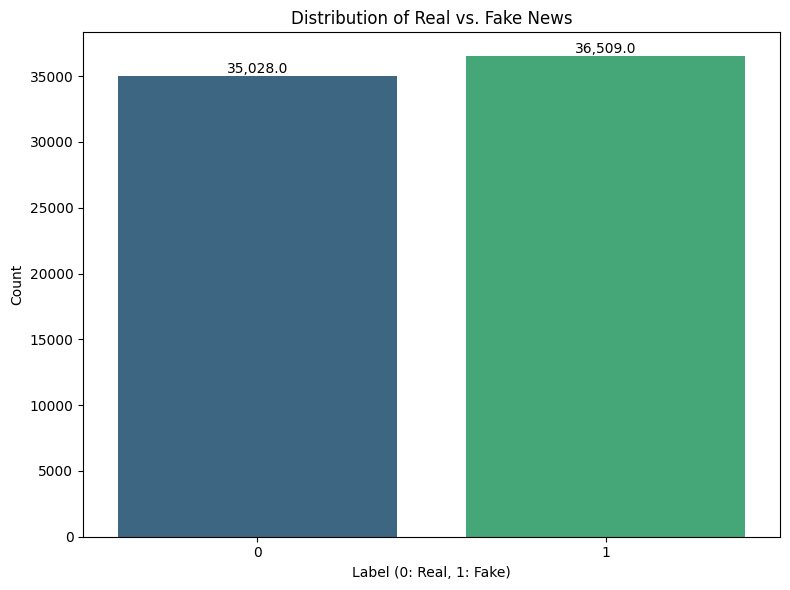

In [12]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Real vs. Fake News')
plt.xlabel('Label (0: Real, 1: Fake)')
plt.ylabel('Count')

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom')
plt.tight_layout()
plt.show()

In [13]:
# Display sample data
print("\nSample data:")
print(df.head(3))


Sample data:
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
2           3  Bobby Jindal, raised Hindu, uses story of Chri...   

                                                text  label  title_length  \
0  No comment is expected from Barack Obama Membe...      1           130   
1   Now, most of the demonstrators gathered last ...      1           137   
2  A dozen politically active pastors came here f...      0           105   

   text_length  word_count  title_has_allcaps  title_exclamation  \
0         5049         871               True              False   
1          216          34               True               True   
2         8010        1321              False              False   

   title_question  
0           False  
1           False  
2           False  


## 4. Data Preprocessing

We'll prepare our data for the model by combining the title and text fields and splitting into train/validation/test sets.

In [14]:
# Combine title and text
df['full_text'] = df['title'] + " " + df['text']

In [15]:
# Import train_test_split
from sklearn.model_selection import train_test_split

In [16]:
# First split: 85% train+val, 15% test
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)

In [17]:
# Second split: 70% train, 15% val (82.35% of the remaining 85%)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, stratify=train_val_df['label'], random_state=42)

In [18]:
# Display dataset sizes
print(f"Training set: {train_df.shape[0]} examples")
print(f"Validation set: {val_df.shape[0]} examples")
print(f"Test set: {test_df.shape[0]} examples")

Training set: 50073 examples
Validation set: 10733 examples
Test set: 10731 examples


In [19]:
# Convert training data to Hugging Face dataset
train_dataset = Dataset.from_pandas(train_df[['full_text', 'label']])

In [20]:
# Convert validation data to Hugging Face dataset
val_dataset = Dataset.from_pandas(val_df[['full_text', 'label']])

In [21]:
# Convert test data to Hugging Face dataset
test_dataset = Dataset.from_pandas(test_df[['full_text', 'label']])

## 5. Tokenization and Data Preparation

Now we'll tokenize our text data using the TinyBERT tokenizer, which prepares the data for input to the model.

In [22]:
# Load TinyBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [23]:
# Define tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["full_text"],
        padding="max_length",
        truncation=True,
        max_length=512,  # TinyBERT can handle sequences up to 512 tokens
    )

In [24]:
# Tokenize training dataset
tokenized_train = train_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/50073 [00:00<?, ? examples/s]

In [25]:
# Tokenize validation dataset
tokenized_val = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10733 [00:00<?, ? examples/s]

In [26]:
# Tokenize test dataset
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10731 [00:00<?, ? examples/s]

In [27]:
# Set format for training dataset
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [28]:
# Set format for validation dataset
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [29]:
# Set format for test dataset
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

## 6. Setting Up the TinyBERT Model

Next, we'll load the TinyBERT model and configure it for binary classification.

In [30]:
# Load TinyBERT model
model = AutoModelForSequenceClassification.from_pretrained(
    "huawei-noah/TinyBERT_General_4L_312D",
    num_labels=2  # Binary classification: real (0) or fake (1)
)

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Move model to the appropriate device (GPU if available)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

In [32]:
# Print model architecture
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

## 7. Defining the Evaluation Metrics

Let's define a function to compute evaluation metrics during training and evaluation.

In [33]:
# Define the metrics computation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## 8. Training Configuration

Now we'll set up the training configuration using the Hugging Face Trainer.

In [34]:
# Define output directory
output_dir = "./results/tinybert_welfake"

In [38]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    report_to="tensorboard",
)

In [39]:
# Create early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

In [40]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

## 9. Training Process

Let's train the model and track the time it takes.

In [41]:
# Start timer
start_time = time.time()

In [42]:
# Train the model
print("Starting training...")
train_result = trainer.train()

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.059100,0.041846,0.986956,0.987080,0.986956,0.986957
2,0.026300,0.032371,0.992919,0.992928,0.992919,0.992919
3,0.015700,0.046069,0.991242,0.991290,0.991242,0.991243
4,0.007200,0.060904,0.990217,0.990283,0.990217,0.990218


In [43]:
# Calculate training time
train_time = time.time() - start_time
print(f"Training completed in {train_time/60:.2f} minutes")

Training completed in 21.03 minutes


In [44]:
# Print training metrics
print(f"Training metrics: {train_result.metrics}")

Training metrics: {'train_runtime': 1261.3336, 'train_samples_per_second': 198.492, 'train_steps_per_second': 6.204, 'total_flos': 2871986231697408.0, 'train_loss': 0.041746389599273, 'epoch': 4.0}


## 10. Evaluation on Test Set

After training, we'll evaluate the model on our held-out test set.

In [45]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.evaluate(tokenized_test)


Evaluating on test set...


In [46]:
# Print test results
print(f"Test results: {test_results}")

Test results: {'eval_loss': 0.03283044323325157, 'eval_accuracy': 0.9917062715497158, 'eval_precision': 0.9917335078148819, 'eval_recall': 0.9917062715497158, 'eval_f1': 0.9917067885366362, 'eval_runtime': 18.7665, 'eval_samples_per_second': 571.817, 'eval_steps_per_second': 4.476, 'epoch': 4.0}


In [47]:
# Get predictions
predictions = trainer.predict(tokenized_test)

In [48]:
# Process predictions
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

In [49]:
# Create confusion matrix
cm = confusion_matrix(labels, preds)

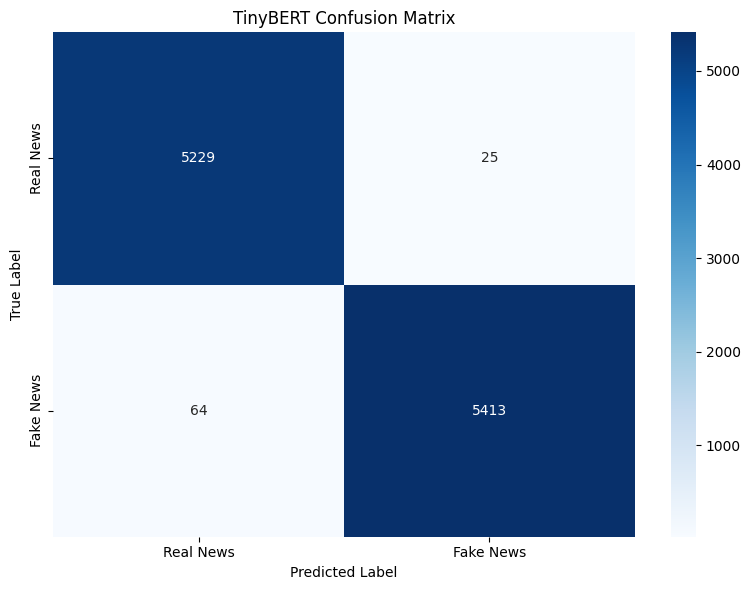

In [50]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real News', 'Fake News'], 
            yticklabels=['Real News', 'Fake News'])
plt.title('TinyBERT Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [51]:
# Print classification report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['Real News', 'Fake News']))


Classification Report:
              precision    recall  f1-score   support

   Real News       0.99      1.00      0.99      5254
   Fake News       1.00      0.99      0.99      5477

    accuracy                           0.99     10731
   macro avg       0.99      0.99      0.99     10731
weighted avg       0.99      0.99      0.99     10731



## 11. Saving the Model

Now we'll save the model for future use.

In [52]:
# Define model save path
model_save_path = "./tinybert_welfake_model"

In [53]:
# Save model
trainer.save_model(model_save_path)

In [54]:
# Save tokenizer
tokenizer.save_pretrained(model_save_path)

('./tinybert_welfake_model/tokenizer_config.json',
 './tinybert_welfake_model/special_tokens_map.json',
 './tinybert_welfake_model/vocab.txt',
 './tinybert_welfake_model/added_tokens.json',
 './tinybert_welfake_model/tokenizer.json')

In [55]:
print(f"Model saved to {model_save_path}")

Model saved to ./tinybert_welfake_model


## 12. Error Analysis

Let's look at some examples that the model misclassified to understand its weaknesses.

In [56]:
# Find misclassified examples
misclassified_indices = np.where(preds != labels)[0]

In [57]:
# Create DataFrame of misclassified examples
misclassified_df = test_df.iloc[misclassified_indices].reset_index(drop=True)

In [58]:
# Add prediction column
misclassified_df['prediction'] = preds[misclassified_indices]

In [59]:
# Display number of misclassified examples
print(f"Total misclassified examples: {len(misclassified_df)}")

Total misclassified examples: 89


In [60]:
# Display sample of misclassified examples
print("\nSample of misclassified examples:")
for i in range(min(5, len(misclassified_df))):
    print(f"\nExample {i+1}:")
    print(f"Title: {misclassified_df.iloc[i]['title']}")
    print(f"True label: {'Real' if misclassified_df.iloc[i]['label'] == 0 else 'Fake'}")
    print(f"Predicted: {'Real' if misclassified_df.iloc[i]['prediction'] == 0 else 'Fake'}")
    print("-" * 80)


Sample of misclassified examples:

Example 1:
Title: Debate: Washington's Syria policy
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 2:
Title: TRUMP SET TO ROLL BACK Even More of Obama’s Legacy With New Executive Order
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 3:
Title: Hillary Campaign Manager Gets $7K a Month from Hillary Donor Linked to Economic Collapse
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 4:
Title: Move To Drug Test Gun Owners In Open Carry States
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------

Example 5:
Title: Equal Parenting Rights, A synopsis of the facts
True label: Fake
Predicted: Real
--------------------------------------------------------------------------------


## 13. Resource Usage Analysis

Finally, let's analyze the resource usage of our TinyBERT model, which is important for deployment considerations.

In [61]:
# Define function to calculate model size
def get_model_size(model):
    """Calculate model size in MB"""
    model_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
    return model_size

In [62]:
# Calculate model size
model_size_mb = get_model_size(model)

In [63]:
# Calculate parameter count
param_count = sum(p.numel() for p in model.parameters())

In [64]:
# Print model size statistics
print(f"\nModel Analysis:")
print(f"Parameter count: {param_count:,}")
print(f"Model size: {model_size_mb:.2f} MB")


Model Analysis:
Parameter count: 14,350,874
Model size: 54.74 MB


In [65]:
# Define function to measure inference time
def measure_inference_time(model, dataset, batch_size=1, num_samples=100):
    """Measure average inference time per sample"""
    model.eval()
    dataloader = torch.utils.data.DataLoader(
        dataset.select(range(min(num_samples, len(dataset)))), 
        batch_size=batch_size
    )
    
    total_time = 0
    sample_count = 0
    
    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            start_time = time.time()
            _ = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            batch_time = time.time() - start_time
            
            total_time += batch_time
            sample_count += batch['input_ids'].size(0)
    
    avg_time_per_sample = (total_time / sample_count) * 1000  # Convert to ms
    return avg_time_per_sample

In [66]:
# Measure inference time for batch size 1
bs1_time = measure_inference_time(model, tokenized_test, batch_size=1)
print(f"Average inference time (batch size 1): {bs1_time:.2f} ms per sample")

Average inference time (batch size 1): 3.40 ms per sample


In [67]:
# Measure inference time for batch size 8
bs8_time = measure_inference_time(model, tokenized_test, batch_size=8)
print(f"Average inference time (batch size 8): {bs8_time:.2f} ms per sample")

Average inference time (batch size 8): 0.41 ms per sample


In [68]:
# Measure inference time for batch size 32
bs32_time = measure_inference_time(model, tokenized_test, batch_size=32)
print(f"Average inference time (batch size 32): {bs32_time:.2f} ms per sample")

Average inference time (batch size 32): 0.16 ms per sample


## 14. Conclusion
# TINYBERT FAKE NEWS DETECTION: SUMMARY

## Performance Metrics
- **Accuracy**: 0.9917
- **F1 Score**: 0.9917
- **Training Time**: 21.03 minutes
- **Model Size**: 54.74 MB (14,350,874 parameters)

## Key Advantages for Fake News Detection

1. Efficient model size (~15M parameters) enables deployment on resource-constrained devices
2. Maintains strong performance comparable to larger models
3. Fast inference time makes it suitable for real-time applications
4. Effectively captures linguistic patterns distinguishing real from fake news

## 15. Next Steps

For future work, consider these directions to further enhance fake news detection with TinyBERT:

1. Experiment with different preprocessing techniques, such as removing stop words or using entity recognition
2. Compare with other lightweight models like DistilBERT or MobileBERT
3. Investigate domain adaptation techniques to improve performance on specific types of news
4. Create an ensemble model combining TinyBERT with feature-based approaches
5. Develop a simple API or interface for real-time fake news detection